In [4]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
import itertools
import mne
from mne.decoding import CSP
from mne import Epochs
from mne.decoding import SPoC
mne.set_log_level(verbose='warning') #to avoid info at terminal
import pickle
import sys
import IO
import os
import multiprocessing

import tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet

from scipy import stats
from collections import OrderedDict
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from bayes_opt import BayesianOptimization
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
import gc
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import XGBRegressor


In [134]:

VICTORIA = False
WRITE_OUT_CH_IND = False
USED_MODEL = 1 # 0 - Enet, 1 - XGB, 2 - NN
settings = {}
VERBOSE_ALL = 0

In [135]:

if VICTORIA is True:
    # insert at 1, 0 is the script path (or '' in REPL)
    sys.path.insert(1, '/home/victoria/icn/icn_m1')
#     settings['BIDS_path'] = "//mnt/Datos/BML_CNCRS/Data_BIDS_new/"
    settings['BIDS_path'] = "D:\Jupyter notebooks\Interventional Cognitive Neuromodulation\data"
    settings['out_path'] = "D:\Jupyter notebooks\Interventional Cognitive Neuromodulation\data\linear models outputs"
    if USED_MODEL==0 :
           settings['out_path_process'] = "/mnt/Datos/BML_CNCRS/Spoc/ECoG_STN/LM_Out/"
    if USED_MODEL==1 :
           settings['out_path_process'] = "/mnt/Datos/BML_CNCRS/Spoc/ECoG_STN/XGB_Out/"
else:
    settings['BIDS_path'] = "D://Jupyter notebooks//Interventional Cognitive Neuromodulation//data//"
    settings['out_path'] = "D://Jupyter notebooks//Interventional Cognitive Neuromodulation//data//linear models outputs//"
    settings['out_path_process'] = "D://Jupyter notebooks//Interventional Cognitive Neuromodulation//data//linear models outputs//process//"

settings['frequencyranges']=[[4, 8], [8, 12], [13, 20], [20, 35], [13, 35], [60, 80], [90, 200], [60, 200]]
settings['seglengths']=[1, 2, 2, 3, 3, 3, 10, 10, 10]
settings['num_patients']=['000']
# settings['num_patients']=['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']

settings['BIDS_path']=settings['BIDS_path'].replace("\\", "/")
settings['out_path']=settings['out_path'].replace("\\", "/")

space_LM = [Real(0, 1, "uniform", name='alpha'),
           Real(0, 1, "uniform", name='l1_ratio')]

space_XGB  = [Integer(1, 100, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Real(10**0, 10**1, "uniform", name="gamma")]

space_NN = [Real(low=1e-4, high=1e-2, prior='log-uniform', name='learning_rate'),
              Integer(low=1, high=3, name='num_dense_layers'),
              Integer(low=1, high=10, prior='uniform', name='num_input_nodes'),
              Integer(low=1, high=10, name='num_dense_nodes'),
              Categorical(categories=['relu', 'tanh'], name='activation')]


In [153]:

def optimize_enet(x,y):

    @use_named_args(space_LM)
    def objective(**params):
        reg=ElasticNet(max_iter=1000, normalize=False)
        reg.set_params(**params)
        cval = cross_val_score(reg, x, y, scoring='r2', cv=3)
        cval[np.where(cval < 0)[0]] = 0

        return -cval.mean()

    res_gp = gp_minimize(objective, space_LM, n_calls=20, random_state=0)
    return res_gp

def create_model_NN():
        """
        Create NN tensorflow with different numbers of hidden layers / hidden units
        """

        #start the model making process and create our first layer
        model = tensorflow.keras.Sequential()
        model.add(Dense(num_input_nodes, input_shape=(40,), activation=activation))

        #create a loop making a new dense layer for the amount passed to this model.
        #naming the layers helps avoid tensorflow error deep in the stack trace.
        for i in range(num_dense_layers):
            name = 'layer_dense_{0}'.format(i+1)
            model.add(BatchNormalization())
            model.add(Dropout(0.2))
            model.add(Dense(num_dense_nodes,
                     activation=activation,
                            name=name
                     ))
        #add our classification layer.
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(1,activation='linear'))

        #setup our optimizer and compile
        adam = Adam(lr=learning_rate)
        model.compile(optimizer=adam, loss='mean_squared_error',
                     metrics=['mse'])
        return model

def optimize_nn(x,y):


    @use_named_args(space_NN)
    def objective(**params):
        print(params)
        global learning_rate
        learning_rate=params["learning_rate"]
        global num_dense_layers
        num_dense_layers=params["num_dense_layers"]
        global num_input_nodes
        num_input_nodes=params["num_input_nodes"]
        global num_dense_nodes
        num_dense_nodes=params["num_dense_nodes"]
        global activation
        activation=params["activation"]

        cv = KFold(n_splits=3, shuffle=True)
        cv_res = []
        with tf.device(tf.DeviceSpec(device_type="")):
            for train_index, test_index in cv.split(x):
                X_train, X_test=x[train_index, :], x[test_index, :]
                y_train, y_test=y[train_index], y[test_index]
                X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8,shuffle=False)
                #model = KerasRegressor(build_fn=create_model_NN, epochs=1000, batch_size=500, verbose=2)
                es = EarlyStopping(monitor='val_mse', mode='min', verbose=VERBOSE_ALL, patience=10)
                mc = ModelCheckpoint('best_model.h5', monitor='val_mse', mode='min', verbose=VERBOSE_ALL, save_best_only=True)
                model = create_model_NN()
                model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=500, verbose=VERBOSE_ALL, callbacks=[mc,es])
                model = load_model('best_model.h5')
                sc = metrics.r2_score(model.predict(X_test), y_test)
                if sc < 0: sc = 0
                cv_res.append(sc)

        #cv_res = cross_val_score(model, x, y, cv=3, n_jobs=59, scoring="r2")
        #cv_res[np.where(cv_res < 0)[0]] = 0
        return -np.mean(cv_res)

    res_gp = gp_minimize(objective, space_NN, n_calls=20, random_state=0)
    return res_gp

def optimize_xgb(x,y):

    def evalerror(preds, dtrain):
        """
        Custom defined r^2 evaluation function
        """
        labels = dtrain.get_label()
        # return a pair metric_name, result. The metric name must not contain a
        # colon (:) or a space since preds are margin(before logistic
        # transformation, cutoff at 0)

        r2 = metrics.r2_score(labels, preds)

        if r2 < 0:
            r2 = 0

        return 'r2', r2

    @use_named_args(space_XGB)
    def objective(**params):
        print(params)

        params_ = {'max_depth': int(params["max_depth"]),
             'gamma': params['gamma'],
             #'n_estimators': int(params["n_estimators"]),
             'learning_rate': params["learning_rate"],
             'subsample': 0.8,
             'eta': 0.1,
             'disable_default_eval_metric' : 1}
             # 'scale_pos_weight ' : 1}
             #'nthread':59}
             #'tree_method' : 'gpu_hist'}
             #'gpu_id' : 1}

        cv_result = xgb.cv(params_, xgb.DMatrix(x, label=y), num_boost_round=30, feval=evalerror, nfold=3)
        return -cv_result['test-r2-mean'].iloc[-1]

    res_gp = gp_minimize(objective, space_XGB, n_calls=20, random_state=0)
    return res_gp


def get_int_runs(subject_id, subfolder):
    """
    :param patient_idx:
    :return: list with all run files for the given patient
    """
    os.listdir(settings['out_path'])

    if 'right' in str(subfolder):
        list_subject = [i for i in os.listdir(settings['out_path']) if i.startswith('sub_'+subject_id+'_sess_right') and i.endswith('.p')]
    else:
        list_subject = [i for i in os.listdir(settings['out_path']) if i.startswith('sub_'+subject_id+'_sess_left') and i.endswith('.p')]

    return list_subject


def append_time_dim(arr, y_, time_stamps):
    """
    apply added time dimension for the data array and label given time_stamps (with downsample_rate=100) in 100ms / need to check with 1375Hz
    """
    time_arr = np.zeros([arr.shape[0]-time_stamps, int(time_stamps*arr.shape[1])])
    for time_idx, time_ in enumerate(np.arange(time_stamps, arr.shape[0])):
        for time_point in range(time_stamps):
            time_arr[time_idx, time_point*arr.shape[1]:(time_point+1)*arr.shape[1]] = arr[time_-time_point,:]
    return time_arr, y_[time_stamps:]
#%%
cv = KFold(n_splits=3, shuffle=False)
# laterality=[("CON"), ("IPS")]
laterality=[("CON")]

# signal=["ECOG", "STN"]
signal=["ECOG"]

#%%cross-val within subject
#for sub_idx in np.arange(0, len(settings['num_patients']), 1):

def run_patient(sub_idx):
    print("IN there")

    for signal_idx, signal_ in enumerate(signal):
        subject_path=settings['BIDS_path'] + 'sub-' + settings['num_patients'][sub_idx]
        subfolder=IO.get_subfolders(subject_path)

        for sess_idx in range(len(subfolder)):
            if os.path.exists(os.path.join(settings['out_path_process'],
                        settings['num_patients'][sub_idx]+'BestChpredictions_'+signal_+'-'+
                            str(subfolder[sess_idx])+'.npy')) is True:
                continue
            X=[]
            Y_con=[]
            Y_ips=[]
            list_subject=get_int_runs(settings['num_patients'][sub_idx], subfolder[sess_idx])
            list_subject=sorted(list_subject)
            if signal_=="ECOG":
                if sub_idx==4 and sess_idx==0: #for sake of comparison with spoc
                    list_subject.pop(0)
                if sub_idx==4 and sess_idx==1:
                    list_subject.pop(2)

            print('RUNNIN SUBJECT_'+ settings['num_patients'][sub_idx]+ '_SESS_'+ str(subfolder[sess_idx]) + '_SIGNAL_' + signal_)

            for run_idx in range(len(list_subject)):
                print(run_idx)
                with open(settings['out_path']+ '/'+ list_subject[run_idx], 'rb') as handle:
                    run_ = pickle.load(handle)

                #concatenate features
                #get cortex data only
                if signal_=="ECOG":
                    ind_cortex=run_['used_channels']['cortex']
                    rf=run_['rf_data_median']
                    x=rf[:,ind_cortex,:]
                    x=np.clip(x, -2,2) # this should have been implemented in the pipeline
                    y=run_['label_baseline_corrected']
                    con_true=run_['label_con_true']
                    y_con=np.squeeze(y[con_true==True])
                    y_ips=np.squeeze(y[con_true==False])
                    X.append(x)
                    Y_con.append(y_con)
                    Y_ips.append(y_ips)
                else:
                    ind_subcortex=run_['used_channels']['subcortex']
                    if ind_subcortex is not None:

                        rf=run_['rf_data_median']
                        x=rf[:,ind_subcortex,:]
                        x=np.clip(x, -2,2)

                        y=run_['label_baseline_corrected']
                        con_true=run_['label_con_true']
                        y_con=np.squeeze(y[con_true==True])
                        y_ips=np.squeeze(y[con_true==False])

                        X.append(x)
                        Y_con.append(y_con)
                        Y_ips.append(y_ips)

            gc.collect() # free unreferenced memory
            
            print(len(X))
            X=np.concatenate(X, axis=0)
            Y_con=np.concatenate(Y_con, axis=0)
            Y_ips=np.concatenate(Y_ips, axis=0)

            Yp_tr= OrderedDict() # Y_predict_train
            sc_tr= OrderedDict() # score_train
            Yp_te= OrderedDict()
            sc_te= OrderedDict()
            Yt_tr= OrderedDict()
            Yt_te= OrderedDict()
            Model_coef= OrderedDict()
            Model_hyperarams= OrderedDict()

            for laterality_idx, laterality_ in enumerate(laterality):
                print("training %s" %laterality_)
                sc_tr[laterality_] = []
                sc_te[laterality_] = []
                Yp_tr[laterality_] = []
                Yp_te[laterality_] = []
                Yt_tr[laterality_] = []
                Yt_te[laterality_] = []
                Model_coef[laterality_] = []
                Model_hyperarams[laterality_] = []


                if laterality_=="CON":
                    label=Y_con
                else:
                    label=Y_ips

                Score_tr=np.empty(X.shape[1], dtype=object)
                Score_te=np.empty(X.shape[1], dtype=object)
                Label_te=np.empty(X.shape[1], dtype=object)
                Label_tr=np.empty(X.shape[1], dtype=object)
                Labelpre_te=np.empty(X.shape[1], dtype=object)
                Labelpre_tr=np.empty(X.shape[1], dtype=object)
                COEF_ = np.empty(X.shape[1],dtype=object)
                Hyperarapms= np.empty(X.shape[1],dtype=object)


                #for each electrode
                for ch_idx in range(X.shape[1]):
                    print("running channel "+str(ch_idx))
                    Ypre_te= []
                    Ypre_tr= []
                    score_tr= []
                    Ypre_te= []
                    score_te= []
                    label_test=[]
                    label_train=[]
                    coords = []
                    coef_ = []
                    hyp_=[]
                    for train_index, test_index in cv.split(X):
                        Xtr, Xte=X[train_index,ch_idx,:], X[test_index,ch_idx,:]
                        Ytr, Yte=label[train_index], label[test_index]
                        label_test.append(Yte)
                        label_train.append(Ytr)
                        dat_tr,label_tr = append_time_dim(Xtr, Ytr, time_stamps=5)
                        dat_te,label_te = append_time_dim(Xte, Yte, time_stamps=5)

                        if USED_MODEL == 0: # Enet
                            optimizer=optimize_enet(x=dat_tr,y=label_tr)
                            model=ElasticNet(alpha=optimizer['x'][0],
                                               l1_ratio=optimizer['x'][1],
                                               max_iter=1000,
                                               normalize=False)
                        elif USED_MODEL == 1: # XGB
                            optimizer=optimize_xgb(x=dat_tr, y=label_tr)
                            model=XGBRegressor(max_depth=optimizer['x'][0],
                                               learning_rate=optimizer['x'][1],
                                               gamma=optimizer['x'][2], subsample= 0.8,
                                               eta= 0.1,
                                               disable_default_eval_metric= 1)

                        elif USED_MODEL == 2:
                            optimizer=optimize_nn(x=dat_tr, y=label_tr)
                            global learning_rate
                            learning_rate=optimizer['x'][0]
                            global num_dense_layers
                            num_dense_layers=optimizer['x'][1]
                            global num_input_nodes
                            num_input_nodes=optimizer['x'][2]
                            global num_dense_nodes
                            num_dense_nodes=optimizer['x'][3]
                            global activation
                            activation=optimizer['x'][4]

                            model = create_model_NN()
                        else:
                            break
                            print("ARCHITECTURE IS NOT DEFINED")

                        if USED_MODEL == 2:

                            es = EarlyStopping(monitor='val_mse', mode='min', verbose=VERBOSE_ALL, patience=10)
                            mc = ModelCheckpoint('best_model.h5', monitor='val_mse', mode='min', verbose=VERBOSE_ALL, save_best_only=True)
                            X_train, X_val, y_train, y_val = train_test_split(dat_tr, label_tr, train_size=0.8,shuffle=True)
                            model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=500, verbose=VERBOSE_ALL, callbacks=[mc,es])
                            r2_tr = metrics.r2_score(model.predict(X_train), y_train)
                            if r2_tr < 0: r2_tr = 0
                            r2_te = metrics.r2_score(model.predict(dat_te), label_te)
                            print("channel: "+str(ch_idx)+" r2 test: "+str(r2_te))
                            if r2_te < 0: r2_te = 0

                        else:
                            model.fit(dat_tr, label_tr)
                            r2_tr=model.score(dat_tr, label_tr)
                            if r2_tr < 0: r2_tr = 0
                            r2_te=model.score(dat_te, label_te)
                            if r2_te < 0: r2_te = 0

                        score_tr.append(r2_tr)
                        score_te.append(r2_te)
                        #with tf.device(tf.DeviceSpec(device_type="CPU", device_index=0)):
                        Ypre_te.append(model.predict(dat_te) if USED_MODEL != 2 else model.predict(dat_te)[:,0])
                        Ypre_tr.append(model.predict(dat_tr) if USED_MODEL != 2 else model.predict(dat_tr)[:,0])
                        if USED_MODEL == 0: coef_.append(model.coef_)
                        hyp_.append(optimizer['x'])

                    Score_tr[ch_idx]=np.mean(score_tr)
                    Score_te[ch_idx]=np.mean(score_te)
                    Label_te[ch_idx]=label_test
                    Label_tr[ch_idx]=label_train
                    Labelpre_te[ch_idx]=Ypre_te
                    Labelpre_tr[ch_idx]=Ypre_tr
                    COEF_[ch_idx]=coef_
                    Hyperarapms[ch_idx]=hyp_

                sc_tr[laterality_] = Score_tr
                sc_te[laterality_] = Score_te
                Yp_tr[laterality_] = Labelpre_te
                Yp_te[laterality_] = Labelpre_tr
                Yt_tr[laterality_] = Label_te
                Yt_te[laterality_] = Label_tr
                Model_coef[laterality_] = COEF_
                Model_hyperarams[laterality_]=Hyperarapms

            predict_ = {
                "y_pred_test": Yp_te,
                "y_test": Yt_te,
                "y_pred_train": Yp_tr,
                "y_train": Yt_tr,
                "score_tr": sc_tr,
                "score_te": sc_te,
                "coord_patient" : run_["coord_patient"],
                "coef" :Model_coef,
                "model_hyperparams": Model_hyperarams


            }
            out_path_file = os.path.join(settings['out_path_process']+ \
                settings['num_patients'][sub_idx]+'BestChpredictions_'+signal_+'-'+ str(subfolder[sess_idx])+'.npy')
            np.save(out_path_file, predict_)


In [154]:
    sub_idx = 0
    for signal_idx, signal_ in enumerate(signal):   
        subject_path=settings['BIDS_path'] + 'sub-' + settings['num_patients'][sub_idx]
        subfolder=IO.get_subfolders(subject_path)
        for sess_idx in range(len(subfolder)):
            
            if os.path.exists(os.path.join(settings['out_path_process'],
                        settings['num_patients'][sub_idx]+'BestChpredictions_'+signal_+'-'+
                            str(subfolder[sess_idx])+'.npy')) is True:
                print("continue")
                continue

            X=[]
            Y_con=[]
            Y_ips=[]
            list_subject=get_int_runs(settings['num_patients'][sub_idx], subfolder[sess_idx])
            list_subject=sorted(list_subject)
            if signal_=="ECOG":
                if sub_idx==4 and sess_idx==0: #for sake of comparison with spoc
                    list_subject.pop(0)
                if sub_idx==4 and sess_idx==1:
                    list_subject.pop(2)

            print('RUNNIN SUBJECT_'+ settings['num_patients'][sub_idx]+ '_SESS_'+ str(subfolder[sess_idx]) + '_SIGNAL_' + signal_)

            print(list_subject)
            for run_idx in range(len(list_subject)):
                print(run_idx)
                with open(settings['out_path']+ '/'+ list_subject[run_idx], 'rb') as handle:
                    run_ = pickle.load(handle)

                #concatenate features
                #get cortex data only
                if signal_=="ECOG":
                    print("checkpoint 1")
                    ind_cortex=run_['used_channels']['cortex']
                    rf=run_['rf_data_median']
                    x=rf[:,ind_cortex,:]
                    x=np.clip(x, -2,2) # this should have been implemented in the pipeline
                    y=run_['label_baseline_corrected']
                    con_true=run_['label_con_true']
                    y_con=np.squeeze(y[con_true==True])
                    y_ips=np.squeeze(y[con_true==False])
                    X.append(x)
                    Y_con.append(y_con)
                    Y_ips.append(y_ips)
                    print("checkpoint 2")
                    print(len(x) )
                else:
                    ind_subcortex=run_['used_channels']['subcortex']
                    if ind_subcortex is not None:

                        rf=run_['rf_data_median']
                        x=rf[:,ind_subcortex,:]
                        x=np.clip(x, -2,2)

                        y=run_['label_baseline_corrected']
                        con_true=run_['label_con_true']
                        y_con=np.squeeze(y[con_true==True])
                        y_ips=np.squeeze(y[con_true==False])

                        X.append(x)
                        Y_con.append(y_con)
                        Y_ips.append(y_ips)

            gc.collect() # free unreferenced memory
            
            print(len(X))
            X=np.concatenate(X, axis=0)
            Y_con=np.concatenate(Y_con, axis=0)
            Y_ips=np.concatenate(Y_ips, axis=0)

            Yp_tr= OrderedDict() # Y_predict_train
            sc_tr= OrderedDict() # score_train
            Yp_te= OrderedDict()
            sc_te= OrderedDict()
            Yt_tr= OrderedDict()
            Yt_te= OrderedDict()
            Model_coef= OrderedDict()
            Model_hyperarams= OrderedDict()
            print("checkpoint 3")
            for laterality_idx, laterality_ in enumerate(laterality):
                print("training %s" %laterality_)
                sc_tr[laterality_] = []
                sc_te[laterality_] = []
                Yp_tr[laterality_] = []
                Yp_te[laterality_] = []
                Yt_tr[laterality_] = []
                Yt_te[laterality_] = []
                Model_coef[laterality_] = []
                Model_hyperarams[laterality_] = []


                if laterality_=="CON":
                    label=Y_con
                else:
                    label=Y_ips

                Score_tr=np.empty(X.shape[1], dtype=object)
                Score_te=np.empty(X.shape[1], dtype=object)
                Label_te=np.empty(X.shape[1], dtype=object)
                Label_tr=np.empty(X.shape[1], dtype=object)
                Labelpre_te=np.empty(X.shape[1], dtype=object)
                Labelpre_tr=np.empty(X.shape[1], dtype=object)
                COEF_ = np.empty(X.shape[1],dtype=object)
                Hyperarapms= np.empty(X.shape[1],dtype=object)
                
                print("checkpoint 4")
                
                

                #for each electrode
                for ch_idx in range(X.shape[1]):
                    print("running channel "+str(ch_idx))
                    Ypre_te= []
                    Ypre_tr= []
                    score_tr= []
                    Ypre_te= []
                    score_te= []
                    label_test=[]
                    label_train=[]
                    coords = []
                    coef_ = []
                    hyp_=[]
                    for train_index, test_index in cv.split(X):
                        Xtr, Xte=X[train_index,ch_idx,:], X[test_index,ch_idx,:]
                        Ytr, Yte=label[train_index], label[test_index]
                        label_test.append(Yte)
                        label_train.append(Ytr)
                        dat_tr,label_tr = append_time_dim(Xtr, Ytr, time_stamps=5)
                        dat_te,label_te = append_time_dim(Xte, Yte, time_stamps=5)

                        print("USED_MODEL",USED_MODEL)
                        
                        if USED_MODEL == 0: # Enet
                            optimizer=optimize_enet(x=dat_tr,y=label_tr)
                            model=ElasticNet(alpha=optimizer['x'][0],
                                               l1_ratio=optimizer['x'][1],
                                               max_iter=1000,
                                               normalize=False)
                        elif USED_MODEL == 1: # XGB
                            optimizer=optimize_xgb(x=dat_tr, y=label_tr)
                            model=XGBRegressor(max_depth=optimizer['x'][0],
                                               learning_rate=optimizer['x'][1],
                                               gamma=optimizer['x'][2], subsample= 0.8,
                                               eta= 0.1,
                                               disable_default_eval_metric= 1)

                        elif USED_MODEL == 2:
                            pass
                            optimizer=optimize_nn(x=dat_tr, y=label_tr)
                            global learning_rate
                            learning_rate=optimizer['x'][0]
                            global num_dense_layers
                            num_dense_layers=optimizer['x'][1]
                            global num_input_nodes
                            num_input_nodes=optimizer['x'][2]
                            global num_dense_nodes
                            num_dense_nodes=optimizer['x'][3]
                            global activation
                            activation=optimizer['x'][4]

                            model = create_model_NN()
                        else:
                            break
                            print("ARCHITECTURE IS NOT DEFINED")

                        if USED_MODEL == 2:

                            es = EarlyStopping(monitor='val_mse', mode='min', verbose=VERBOSE_ALL, patience=10)
                            mc = ModelCheckpoint('best_model.h5', monitor='val_mse', mode='min', verbose=VERBOSE_ALL, save_best_only=True)
                            X_train, X_val, y_train, y_val = train_test_split(dat_tr, label_tr, train_size=0.8,shuffle=True)
                            model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=500, verbose=VERBOSE_ALL, callbacks=[mc,es])
                            r2_tr = metrics.r2_score(model.predict(X_train), y_train)
                            if r2_tr < 0: r2_tr = 0
                            r2_te = metrics.r2_score(model.predict(dat_te), label_te)
                            print("channel: "+str(ch_idx)+" r2 test: "+str(r2_te))
                            if r2_te < 0: r2_te = 0

                        else:
                            model.fit(dat_tr, label_tr)
                            r2_tr=model.score(dat_tr, label_tr)
                            if r2_tr < 0: r2_tr = 0
                            r2_te=model.score(dat_te, label_te)
                            if r2_te < 0: r2_te = 0

                        score_tr.append(r2_tr)
                        score_te.append(r2_te)
                        #with tf.device(tf.DeviceSpec(device_type="CPU", device_index=0)):
                        Ypre_te.append(model.predict(dat_te) if USED_MODEL != 2 else model.predict(dat_te)[:,0])
                        Ypre_tr.append(model.predict(dat_tr) if USED_MODEL != 2 else model.predict(dat_tr)[:,0])
                        if USED_MODEL == 0: coef_.append(model.coef_)
                        hyp_.append(optimizer['x'])
                        

                        score_tr.append(r2_tr)
                        score_te.append(r2_te)
                        #with tf.device(tf.DeviceSpec(device_type="CPU", device_index=0)):
                        Ypre_te.append(model.predict(dat_te) if USED_MODEL != 2 else model.predict(dat_te)[:,0])
                        Ypre_tr.append(model.predict(dat_tr) if USED_MODEL != 2 else model.predict(dat_tr)[:,0])
                        if USED_MODEL == 0: coef_.append(model.coef_)
                        hyp_.append(optimizer['x'])

                    Score_tr[ch_idx]=np.mean(score_tr)
                    Score_te[ch_idx]=np.mean(score_te)
                    Label_te[ch_idx]=label_test
                    Label_tr[ch_idx]=label_train
                    Labelpre_te[ch_idx]=Ypre_te
                    Labelpre_tr[ch_idx]=Ypre_tr
                    COEF_[ch_idx]=coef_
                    Hyperarapms[ch_idx]=hyp_

                sc_tr[laterality_] = Score_tr
                sc_te[laterality_] = Score_te
                Yp_tr[laterality_] = Labelpre_te
                Yp_te[laterality_] = Labelpre_tr
                Yt_tr[laterality_] = Label_te
                Yt_te[laterality_] = Label_tr
                Model_coef[laterality_] = COEF_
                Model_hyperarams[laterality_]=Hyperarapms
                
            predict_ = {
                "y_pred_test": Yp_te,
                "y_test": Yt_te,
                "y_pred_train": Yp_tr,
                "y_train": Yt_tr,
                "score_tr": sc_tr,
                "score_te": sc_te,
                "coord_patient" : run_["coord_patient"],
                "coef" :Model_coef,
                "model_hyperparams": Model_hyperarams
                

            }
            out_path_file = os.path.join(settings['out_path_process']+ \
                settings['num_patients'][sub_idx]+'BestChpredictions_'+signal_+'-'+ str(subfolder[sess_idx])+'.npy')
            np.save(out_path_file, predict_)
            
            print("checkpoint 5")

            
                

ses-right
RUNNIN SUBJECT_000_SESS_ses-right_SIGNAL_ECOG
['sub_000_sess_right_run_0.p']
0
checkpoint 1
checkpoint 2
1290
1
checkpoint 3
training CON
checkpoint 4
running channel 0
USED_MODEL 1
{'max_depth': 60, 'learning_rate': 0.16646722614124754, 'gamma': 8.721510558604813}
{'max_depth': 85, 'learning_rate': 0.013116515715358098, 'gamma': 4.459435365634299}
{'max_depth': 30, 'learning_rate': 1.921165975741198e-05, 'gamma': 3.4539066512210193}
{'max_depth': 48, 'learning_rate': 0.11503861485898605, 'gamma': 5.319794551375517}
{'max_depth': 40, 'learning_rate': 0.15149343663386153, 'gamma': 4.036565443755416}
{'max_depth': 65, 'learning_rate': 0.0006937575128144787, 'gamma': 9.61439643057742}
{'max_depth': 15, 'learning_rate': 0.22409712855921127, 'gamma': 5.262472407463395}
{'max_depth': 80, 'learning_rate': 0.004003016661601729, 'gamma': 7.109915771070644}
{'max_depth': 72, 'learning_rate': 0.008130157526376589, 'gamma': 5.836359065041097}
{'max_depth': 76, 'learning_rate': 3.38483915

{'max_depth': 48, 'learning_rate': 0.11503861485898605, 'gamma': 5.319794551375517}
{'max_depth': 40, 'learning_rate': 0.15149343663386153, 'gamma': 4.036565443755416}
{'max_depth': 65, 'learning_rate': 0.0006937575128144787, 'gamma': 9.61439643057742}
{'max_depth': 15, 'learning_rate': 0.22409712855921127, 'gamma': 5.262472407463395}
{'max_depth': 80, 'learning_rate': 0.004003016661601729, 'gamma': 7.109915771070644}
{'max_depth': 72, 'learning_rate': 0.008130157526376589, 'gamma': 5.836359065041097}
{'max_depth': 76, 'learning_rate': 3.3848391532325447e-05, 'gamma': 5.262403774119917}
{'max_depth': 32, 'learning_rate': 1.0, 'gamma': 10.0}
{'max_depth': 39, 'learning_rate': 0.18179052728760212, 'gamma': 2.8537868541857856}
{'max_depth': 95, 'learning_rate': 0.9774523697850083, 'gamma': 1.0}
{'max_depth': 34, 'learning_rate': 0.20584038187359133, 'gamma': 2.273040644124962}
{'max_depth': 1, 'learning_rate': 0.2682210045707671, 'gamma': 1.0}
{'max_depth': 56, 'learning_rate': 0.34287772

{'max_depth': 15, 'learning_rate': 0.22409712855921127, 'gamma': 5.262472407463395}
{'max_depth': 80, 'learning_rate': 0.004003016661601729, 'gamma': 7.109915771070644}
{'max_depth': 72, 'learning_rate': 0.008130157526376589, 'gamma': 5.836359065041097}
{'max_depth': 76, 'learning_rate': 3.3848391532325447e-05, 'gamma': 5.262403774119917}
{'max_depth': 31, 'learning_rate': 1.0, 'gamma': 10.0}
{'max_depth': 36, 'learning_rate': 0.17292992089835715, 'gamma': 3.53763992933711}
{'max_depth': 100, 'learning_rate': 0.8618686344542599, 'gamma': 1.5702195633704075}
{'max_depth': 66, 'learning_rate': 0.44370166127702987, 'gamma': 1.799685035404825}
{'max_depth': 1, 'learning_rate': 0.32205824555906065, 'gamma': 1.0}
{'max_depth': 52, 'learning_rate': 1.0, 'gamma': 2.430508737947426}
{'max_depth': 100, 'learning_rate': 0.32579059030934554, 'gamma': 1.0}
{'max_depth': 100, 'learning_rate': 0.3083738696881428, 'gamma': 2.3059284507119275}
{'max_depth': 86, 'learning_rate': 0.27280110252268497, 'ga

{'max_depth': 31, 'learning_rate': 1.0, 'gamma': 10.0}
{'max_depth': 34, 'learning_rate': 0.1922082641145285, 'gamma': 3.0749448279548774}
{'max_depth': 100, 'learning_rate': 0.7718493016752508, 'gamma': 1.0}
{'max_depth': 34, 'learning_rate': 0.22652871935752358, 'gamma': 2.3776067300515544}
{'max_depth': 17, 'learning_rate': 0.23249492225164803, 'gamma': 1.0}
{'max_depth': 1, 'learning_rate': 0.4647698358505954, 'gamma': 1.0}
{'max_depth': 92, 'learning_rate': 0.1643962826217829, 'gamma': 1.0}
{'max_depth': 1, 'learning_rate': 0.18034198019668557, 'gamma': 1.0}
{'max_depth': 100, 'learning_rate': 0.2400297339076809, 'gamma': 1.0}
{'max_depth': 100, 'learning_rate': 0.23361454185147154, 'gamma': 1.0}
USED_MODEL 1
{'max_depth': 60, 'learning_rate': 0.16646722614124754, 'gamma': 8.721510558604813}
{'max_depth': 85, 'learning_rate': 0.013116515715358098, 'gamma': 4.459435365634299}
{'max_depth': 30, 'learning_rate': 1.921165975741198e-05, 'gamma': 3.4539066512210193}
{'max_depth': 48, 'l

In [156]:
predict_.keys()

dict_keys(['y_pred_test', 'y_test', 'y_pred_train', 'y_train', 'score_tr', 'score_te', 'coord_patient', 'coef', 'model_hyperparams'])

In [161]:
predict_['y_pred_test']['CON']

array([list([array([ 0.01173872,  0.01173872,  0.01173872,  0.01173872,  0.01173872,
        0.01173872,  0.01173872,  0.01173872,  0.01173872,  0.01173872,
        0.01173872,  0.01173872,  0.01173872,  0.01173872,  0.01173872,
        0.01173872,  0.01173872,  0.01173872,  0.01173872,  0.01173872,
        0.01173872,  0.01173872,  0.01173872,  0.01173872,  0.01173872,
        0.01173872,  0.01173872,  0.01173872,  0.01173872,  0.01173872,
        0.01173872,  0.01173872,  0.01173872,  0.01173872,  0.01173872,
        0.01173872,  0.01173872,  0.01173872,  0.01173872,  0.01173872,
        0.01173872,  0.01173872,  0.01173872,  0.01173872,  0.01173872,
        0.01173872,  0.01173872,  0.01173872,  0.01173872,  0.01173872,
        0.01173872,  0.01173872,  0.01173872,  0.01173872,  0.01173872,
        0.01173872,  0.01173872,  0.01173872,  0.01173872,  0.01217343,
        0.05476931,  0.19242391,  0.09781406,  0.00877817,  0.04481968,
        0.01217343,  0.01217343,  0.01217343,  0.01

# Elastic net


In [162]:
USED_MODEL = 0

In [163]:
    sub_idx = 0
    for signal_idx, signal_ in enumerate(signal):   
        subject_path=settings['BIDS_path'] + 'sub-' + settings['num_patients'][sub_idx]
        subfolder=IO.get_subfolders(subject_path)
        for sess_idx in range(len(subfolder)):
            
            if os.path.exists(os.path.join(settings['out_path_process'],
                        settings['num_patients'][sub_idx]+'BestChpredictions_'+signal_+'-'+
                            str(subfolder[sess_idx])+'.npy')) is True:
                print("continue")
                continue

            X=[]
            Y_con=[]
            Y_ips=[]
            list_subject=get_int_runs(settings['num_patients'][sub_idx], subfolder[sess_idx])
            list_subject=sorted(list_subject)
            if signal_=="ECOG":
                if sub_idx==4 and sess_idx==0: #for sake of comparison with spoc
                    list_subject.pop(0)
                if sub_idx==4 and sess_idx==1:
                    list_subject.pop(2)

            print('RUNNIN SUBJECT_'+ settings['num_patients'][sub_idx]+ '_SESS_'+ str(subfolder[sess_idx]) + '_SIGNAL_' + signal_)

            print(list_subject)
            for run_idx in range(len(list_subject)):
                print(run_idx)
                with open(settings['out_path']+ '/'+ list_subject[run_idx], 'rb') as handle:
                    run_ = pickle.load(handle)

                #concatenate features
                #get cortex data only
                if signal_=="ECOG":
                    print("checkpoint 1")
                    ind_cortex=run_['used_channels']['cortex']
                    rf=run_['rf_data_median']
                    x=rf[:,ind_cortex,:]
                    x=np.clip(x, -2,2) # this should have been implemented in the pipeline
                    y=run_['label_baseline_corrected']
                    con_true=run_['label_con_true']
                    y_con=np.squeeze(y[con_true==True])
                    y_ips=np.squeeze(y[con_true==False])
                    X.append(x)
                    Y_con.append(y_con)
                    Y_ips.append(y_ips)
                    print("checkpoint 2")
                    print(len(x) )
                else:
                    ind_subcortex=run_['used_channels']['subcortex']
                    if ind_subcortex is not None:

                        rf=run_['rf_data_median']
                        x=rf[:,ind_subcortex,:]
                        x=np.clip(x, -2,2)

                        y=run_['label_baseline_corrected']
                        con_true=run_['label_con_true']
                        y_con=np.squeeze(y[con_true==True])
                        y_ips=np.squeeze(y[con_true==False])

                        X.append(x)
                        Y_con.append(y_con)
                        Y_ips.append(y_ips)

            gc.collect() # free unreferenced memory
            
            print(len(X))
            X=np.concatenate(X, axis=0)
            Y_con=np.concatenate(Y_con, axis=0)
            Y_ips=np.concatenate(Y_ips, axis=0)

            Yp_tr= OrderedDict() # Y_predict_train
            sc_tr= OrderedDict() # score_train
            Yp_te= OrderedDict()
            sc_te= OrderedDict()
            Yt_tr= OrderedDict()
            Yt_te= OrderedDict()
            Model_coef= OrderedDict()
            Model_hyperarams= OrderedDict()
            print("checkpoint 3")
            for laterality_idx, laterality_ in enumerate(laterality):
                print("training %s" %laterality_)
                sc_tr[laterality_] = []
                sc_te[laterality_] = []
                Yp_tr[laterality_] = []
                Yp_te[laterality_] = []
                Yt_tr[laterality_] = []
                Yt_te[laterality_] = []
                Model_coef[laterality_] = []
                Model_hyperarams[laterality_] = []


                if laterality_=="CON":
                    label=Y_con
                else:
                    label=Y_ips

                Score_tr=np.empty(X.shape[1], dtype=object)
                Score_te=np.empty(X.shape[1], dtype=object)
                Label_te=np.empty(X.shape[1], dtype=object)
                Label_tr=np.empty(X.shape[1], dtype=object)
                Labelpre_te=np.empty(X.shape[1], dtype=object)
                Labelpre_tr=np.empty(X.shape[1], dtype=object)
                COEF_ = np.empty(X.shape[1],dtype=object)
                Hyperarapms= np.empty(X.shape[1],dtype=object)
                
                print("checkpoint 4")
                
                

                #for each electrode
                for ch_idx in range(X.shape[1]):
                    print("running channel "+str(ch_idx))
                    Ypre_te= []
                    Ypre_tr= []
                    score_tr= []
                    Ypre_te= []
                    score_te= []
                    label_test=[]
                    label_train=[]
                    coords = []
                    coef_ = []
                    hyp_=[]
                    for train_index, test_index in cv.split(X):
                        Xtr, Xte=X[train_index,ch_idx,:], X[test_index,ch_idx,:]
                        Ytr, Yte=label[train_index], label[test_index]
                        label_test.append(Yte)
                        label_train.append(Ytr)
                        dat_tr,label_tr = append_time_dim(Xtr, Ytr, time_stamps=5)
                        dat_te,label_te = append_time_dim(Xte, Yte, time_stamps=5)

                        print("USED_MODEL",USED_MODEL)
                        
                        if USED_MODEL == 0: # Enet
                            optimizer=optimize_enet(x=dat_tr,y=label_tr)
                            model=ElasticNet(alpha=optimizer['x'][0],
                                               l1_ratio=optimizer['x'][1],
                                               max_iter=1000,
                                               normalize=False)
                        elif USED_MODEL == 1: # XGB
                            optimizer=optimize_xgb(x=dat_tr, y=label_tr)
                            model=XGBRegressor(max_depth=optimizer['x'][0],
                                               learning_rate=optimizer['x'][1],
                                               gamma=optimizer['x'][2], subsample= 0.8,
                                               eta= 0.1,
                                               disable_default_eval_metric= 1)

                        elif USED_MODEL == 2:
                            pass
                            optimizer=optimize_nn(x=dat_tr, y=label_tr)
                            global learning_rate
                            learning_rate=optimizer['x'][0]
                            global num_dense_layers
                            num_dense_layers=optimizer['x'][1]
                            global num_input_nodes
                            num_input_nodes=optimizer['x'][2]
                            global num_dense_nodes
                            num_dense_nodes=optimizer['x'][3]
                            global activation
                            activation=optimizer['x'][4]

                            model = create_model_NN()
                        else:
                            break
                            print("ARCHITECTURE IS NOT DEFINED")

                        if USED_MODEL == 2:

                            es = EarlyStopping(monitor='val_mse', mode='min', verbose=VERBOSE_ALL, patience=10)
                            mc = ModelCheckpoint('best_model.h5', monitor='val_mse', mode='min', verbose=VERBOSE_ALL, save_best_only=True)
                            X_train, X_val, y_train, y_val = train_test_split(dat_tr, label_tr, train_size=0.8,shuffle=True)
                            model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=500, verbose=VERBOSE_ALL, callbacks=[mc,es])
                            r2_tr = metrics.r2_score(model.predict(X_train), y_train)
                            if r2_tr < 0: r2_tr = 0
                            r2_te = metrics.r2_score(model.predict(dat_te), label_te)
                            print("channel: "+str(ch_idx)+" r2 test: "+str(r2_te))
                            if r2_te < 0: r2_te = 0

                        else:
                            model.fit(dat_tr, label_tr)
                            r2_tr=model.score(dat_tr, label_tr)
                            if r2_tr < 0: r2_tr = 0
                            r2_te=model.score(dat_te, label_te)
                            if r2_te < 0: r2_te = 0

                        score_tr.append(r2_tr)
                        score_te.append(r2_te)
                        #with tf.device(tf.DeviceSpec(device_type="CPU", device_index=0)):
                        Ypre_te.append(model.predict(dat_te) if USED_MODEL != 2 else model.predict(dat_te)[:,0])
                        Ypre_tr.append(model.predict(dat_tr) if USED_MODEL != 2 else model.predict(dat_tr)[:,0])
                        if USED_MODEL == 0: coef_.append(model.coef_)
                        hyp_.append(optimizer['x'])
                        

                        score_tr.append(r2_tr)
                        score_te.append(r2_te)
                        #with tf.device(tf.DeviceSpec(device_type="CPU", device_index=0)):
                        Ypre_te.append(model.predict(dat_te) if USED_MODEL != 2 else model.predict(dat_te)[:,0])
                        Ypre_tr.append(model.predict(dat_tr) if USED_MODEL != 2 else model.predict(dat_tr)[:,0])
                        if USED_MODEL == 0: coef_.append(model.coef_)
                        hyp_.append(optimizer['x'])

                    Score_tr[ch_idx]=np.mean(score_tr)
                    Score_te[ch_idx]=np.mean(score_te)
                    Label_te[ch_idx]=label_test
                    Label_tr[ch_idx]=label_train
                    Labelpre_te[ch_idx]=Ypre_te
                    Labelpre_tr[ch_idx]=Ypre_tr
                    COEF_[ch_idx]=coef_
                    Hyperarapms[ch_idx]=hyp_

                sc_tr[laterality_] = Score_tr
                sc_te[laterality_] = Score_te
                Yp_tr[laterality_] = Labelpre_te
                Yp_te[laterality_] = Labelpre_tr
                Yt_tr[laterality_] = Label_te
                Yt_te[laterality_] = Label_tr
                Model_coef[laterality_] = COEF_
                Model_hyperarams[laterality_]=Hyperarapms
                
            predict_ = {
                "y_pred_test": Yp_te,
                "y_test": Yt_te,
                "y_pred_train": Yp_tr,
                "y_train": Yt_tr,
                "score_tr": sc_tr,
                "score_te": sc_te,
                "coord_patient" : run_["coord_patient"],
                "coef" :Model_coef,
                "model_hyperparams": Model_hyperarams
                

            }
            out_path_file = os.path.join(settings['out_path_process']+ \
                settings['num_patients'][sub_idx]+'BestChpredictions_'+signal_+'-'+ str(subfolder[sess_idx])+'.npy')
            np.save(out_path_file, predict_)
            
            print("checkpoint 5")

            
                

ses-right
RUNNIN SUBJECT_000_SESS_ses-right_SIGNAL_ECOG
['sub_000_sess_right_run_0.p']
0
checkpoint 1
checkpoint 2
1290
1
checkpoint 3
training CON
checkpoint 4
running channel 0
USED_MODEL 0


C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.006091498014182, tolerance: 0.003706585260639231
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimat

C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.006091498014182, tolerance: 0.003706585260639231
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimat

USED_MODEL 0


C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.117912181127108, tolerance: 0.004095794319610956
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.522130319372316, tolerance: 0.0031913278122970073
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.254118450893213, tolerance: 0.004454303353858451
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarni

C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.143651557261784, tolerance: 0.004095794319610956
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.979913321521105, tolerance: 0.0031913278122970073
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.252248503943822, tolerance: 0.004454303353858451
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarni

USED_MODEL 0


C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.17918547877391, tolerance: 0.002930817357144227
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimato

running channel 1
USED_MODEL 0


C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.859695033081285, tolerance: 0.003706585260639231
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimat

USED_MODEL 0


C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.880155953620196, tolerance: 0.004095794319610956
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimat

USED_MODEL 0


C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.946696924874991, tolerance: 0.002930817357144227
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimat

C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.946696924874991, tolerance: 0.002930817357144227
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimat

running channel 2
USED_MODEL 0


C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.470784857413923, tolerance: 0.003706585260639231
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimat

USED_MODEL 0


C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.924981986851883, tolerance: 0.004095794319610956
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimat

C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.751509325532886, tolerance: 0.004095794319610956
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.1933999452962, tolerance: 0.0031913278122970073
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.382448085007425, tolerance: 0.004454303353858451
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning

USED_MODEL 0


C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.758678640348464, tolerance: 0.002930817357144227
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimat

C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.758678640348464, tolerance: 0.002930817357144227
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimat

running channel 3
USED_MODEL 0


C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.013402343497912, tolerance: 0.003706585260639231
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimat

C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.013402343497912, tolerance: 0.003706585260639231
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimat

USED_MODEL 0


C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.990976119779703, tolerance: 0.004095794319610956
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimat

C:\Users\mousa\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.990976119779703, tolerance: 0.004095794319610956
  model = cd_fast.enet_coordinate_descent(
C:\User

USED_MODEL 0


C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.883523954828759, tolerance: 0.002930817357144227
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimat

running channel 4
USED_MODEL 0


C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.8078094829959275, tolerance: 0.003706585260639231
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estima

C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.8078094829959275, tolerance: 0.003706585260639231
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estima

USED_MODEL 0


C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.176310034825093, tolerance: 0.004095794319610956
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimat

C:\Users\mousa\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.176310034825093, tolerance: 0.004095794319610956
  model = cd_fast.enet_coordinate_descent(
C:\User

USED_MODEL 0


C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.627804817336832, tolerance: 0.002930817357144227
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimat

C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.627804817336832, tolerance: 0.002930817357144227
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimat

running channel 5
USED_MODEL 0


C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.229802290912799, tolerance: 0.003706585260639231
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimat

C:\Users\mousa\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.229802290912799, tolerance: 0.003706585260639231
  model = cd_fast.enet_coordinate_descent(
C:\User

USED_MODEL 0


C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.78899042143637, tolerance: 0.004095794319610956
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimato

C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.78899042143637, tolerance: 0.004095794319610956
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimato

USED_MODEL 0


C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.434387340748692, tolerance: 0.002930817357144227
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimat

C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.788804838908973, tolerance: 0.002930817357144227
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.491359873197325, tolerance: 0.0026840419674583242
  model = cd_fast.enet_coordinate_descent(
C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.046696086392785, tolerance: 0.003819822274199865
  model = cd_fast.enet_coordinate_descent(


checkpoint 5


C:\Users\mousa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.749320591368186, tolerance: 0.00473801015132556
  model = cd_fast.enet_coordinate_descent(


In [170]:
predict_["y_pred_test"]["CON"]

array([list([array([-8.05038607e-03, -2.39521230e-02,  2.23346527e-02, -2.74960956e-02,
       -6.82109067e-02, -6.90420235e-02, -3.90205063e-02, -4.51399250e-02,
       -4.37130065e-02, -2.85705490e-02, -1.12563517e-02,  5.00854056e-03,
       -1.53833843e-03, -1.61976373e-02, -1.66401066e-02, -1.18100369e-02,
       -4.02981568e-03, -3.79363330e-02, -3.07991088e-02, -5.02990863e-02,
       -4.03770445e-02, -5.77769919e-02, -4.30653179e-02, -3.63856547e-02,
       -1.04099106e-02, -7.41407614e-03, -1.48921855e-03,  1.26053952e-03,
       -2.70044392e-04, -6.74460927e-03, -5.23651414e-03, -1.81089217e-02,
        5.00387082e-03,  2.71706023e-02,  3.78757704e-02,  1.60776101e-02,
        4.73103819e-02,  1.30080626e-02,  5.23946428e-03, -8.14331081e-03,
       -1.88320808e-02, -1.59067434e-02,  2.39228304e-03, -1.49274508e-03,
       -3.14445566e-02, -3.01606301e-02, -2.63310769e-02, -4.63452117e-03,
       -7.56245620e-03, -2.01732640e-03,  2.18960183e-02,  1.99167419e-02,
       -4.81

In [180]:
predict_.keys()

dict_keys(['y_pred_test', 'y_test', 'y_pred_train', 'y_train', 'score_tr', 'score_te', 'coord_patient', 'coef', 'model_hyperparams'])

In [194]:
predict_['y_test']['CON'][0][0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

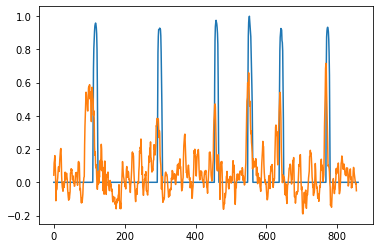

In [205]:
ch = 5

plt.plot(predict_["y_test"]['CON'][0][0])
plt.plot(predict_["y_pred_test"]['CON'][ch][0])